# Muti-task Rodent TBI segmentation with Domain Adaptation
### Skull-stripping and ROI Segmentation

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Evaluation Metrics](#metrics)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [1]:
import numpy as np
import os
import importlib
import pandas as pd
import time

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

# fix random seed for reproducibility
seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

# Set tensorflow to use mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

Num GPUs Available:  1
2.10.0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A4000, compute capability 8.6


# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
Problem: Skull-stripping and ROI semantic segmentation<br>
Each pixel in the image has to be assigned one of the following labels: <br>
- Background (label 0)
- Lesion (red, label 1)
- CC contra (green, label 2)
- CC ipsi (dark blue, label 12)
- Ventricle contra (blue, label 3)
- Ventricle ipsi (light green, label 13)
- Hippo contra (cyan, label 5)
- Hippo ipsi (light brown, label 15)
- Cortex contra (pink, label 6)
- Cortex ispi (light blue, label 16)
- Third Ventricle (purple, label 21)

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1w (Flash)**
2. **T2w (Rare)**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [2]:
config ={
    'dataset_path': 'F:\\Lesion Volume Project\\backup temp\\dataset_roi_cot',
    'input_shape': (80, 80, 80),
    'target_resolution': (0.1,0.1,0.1),
    'labels': [0,1,2,3,5,6,12,13,15,16,21],
    'num_classes': 11,
    'in_channels': 1,
    'batch_size': 8,
    'epochs': 300,
    'lr': 1e-3,
    'model_name': "mice_da_unet" + "_ep" + str(500) + time.strftime("_%d-%m-%Y_%H-%M"),
    'validation_split': 0.2,
    'test_split': 0.1,
    'sampling_rate': 3,
}

# 5. Data Visualization <a class='anchor' id='visual'></a> [↑](#top)

F:\Lesion Volume Project\backup temp\dataset_roi_cot\TBI-t2w-c52-4\TBI_fm_19_50\Anat


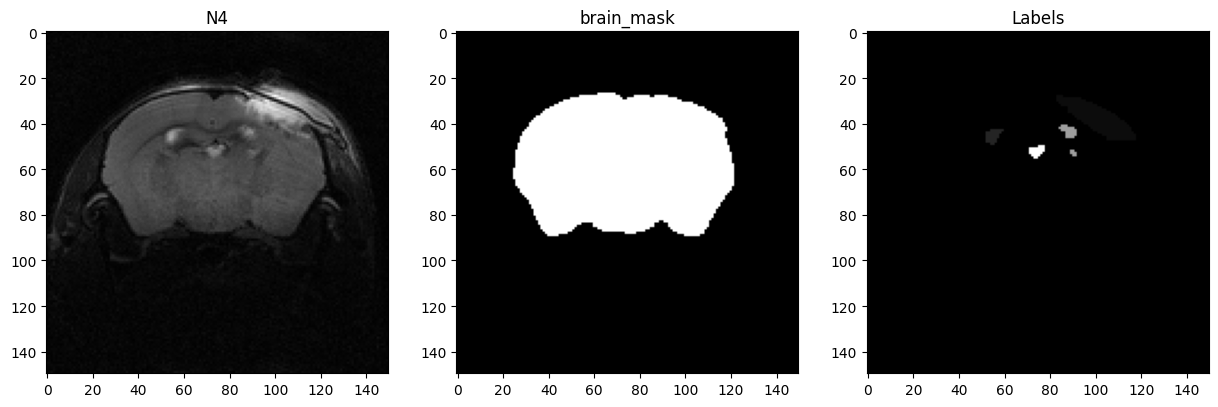

In [3]:
import utils.visualization
importlib.reload(utils.visualization)
from utils.visualization import *
from utils.loader import load_data

# Modalities
modalities = ['N4', 'brain_mask', 'Labels']

# Rodent scan
scan_type = 'TBI-t2w-c52-4'
scan_id = 'TBI_fm_19_50'
scan_folder = os.path.join(config['dataset_path'], scan_type, scan_id, 'Anat')
print(scan_folder)

# Load data
img, data, file_paths = load_data(scan_folder, scan_id, modalities)

# Plot data
plot_data(data)

In [4]:
# Check unique values in the lesion mask
print(f"Unique values in the lesion mask: {np.unique(data['brain_mask'])}")

Unique values in the lesion mask: [0. 1.]


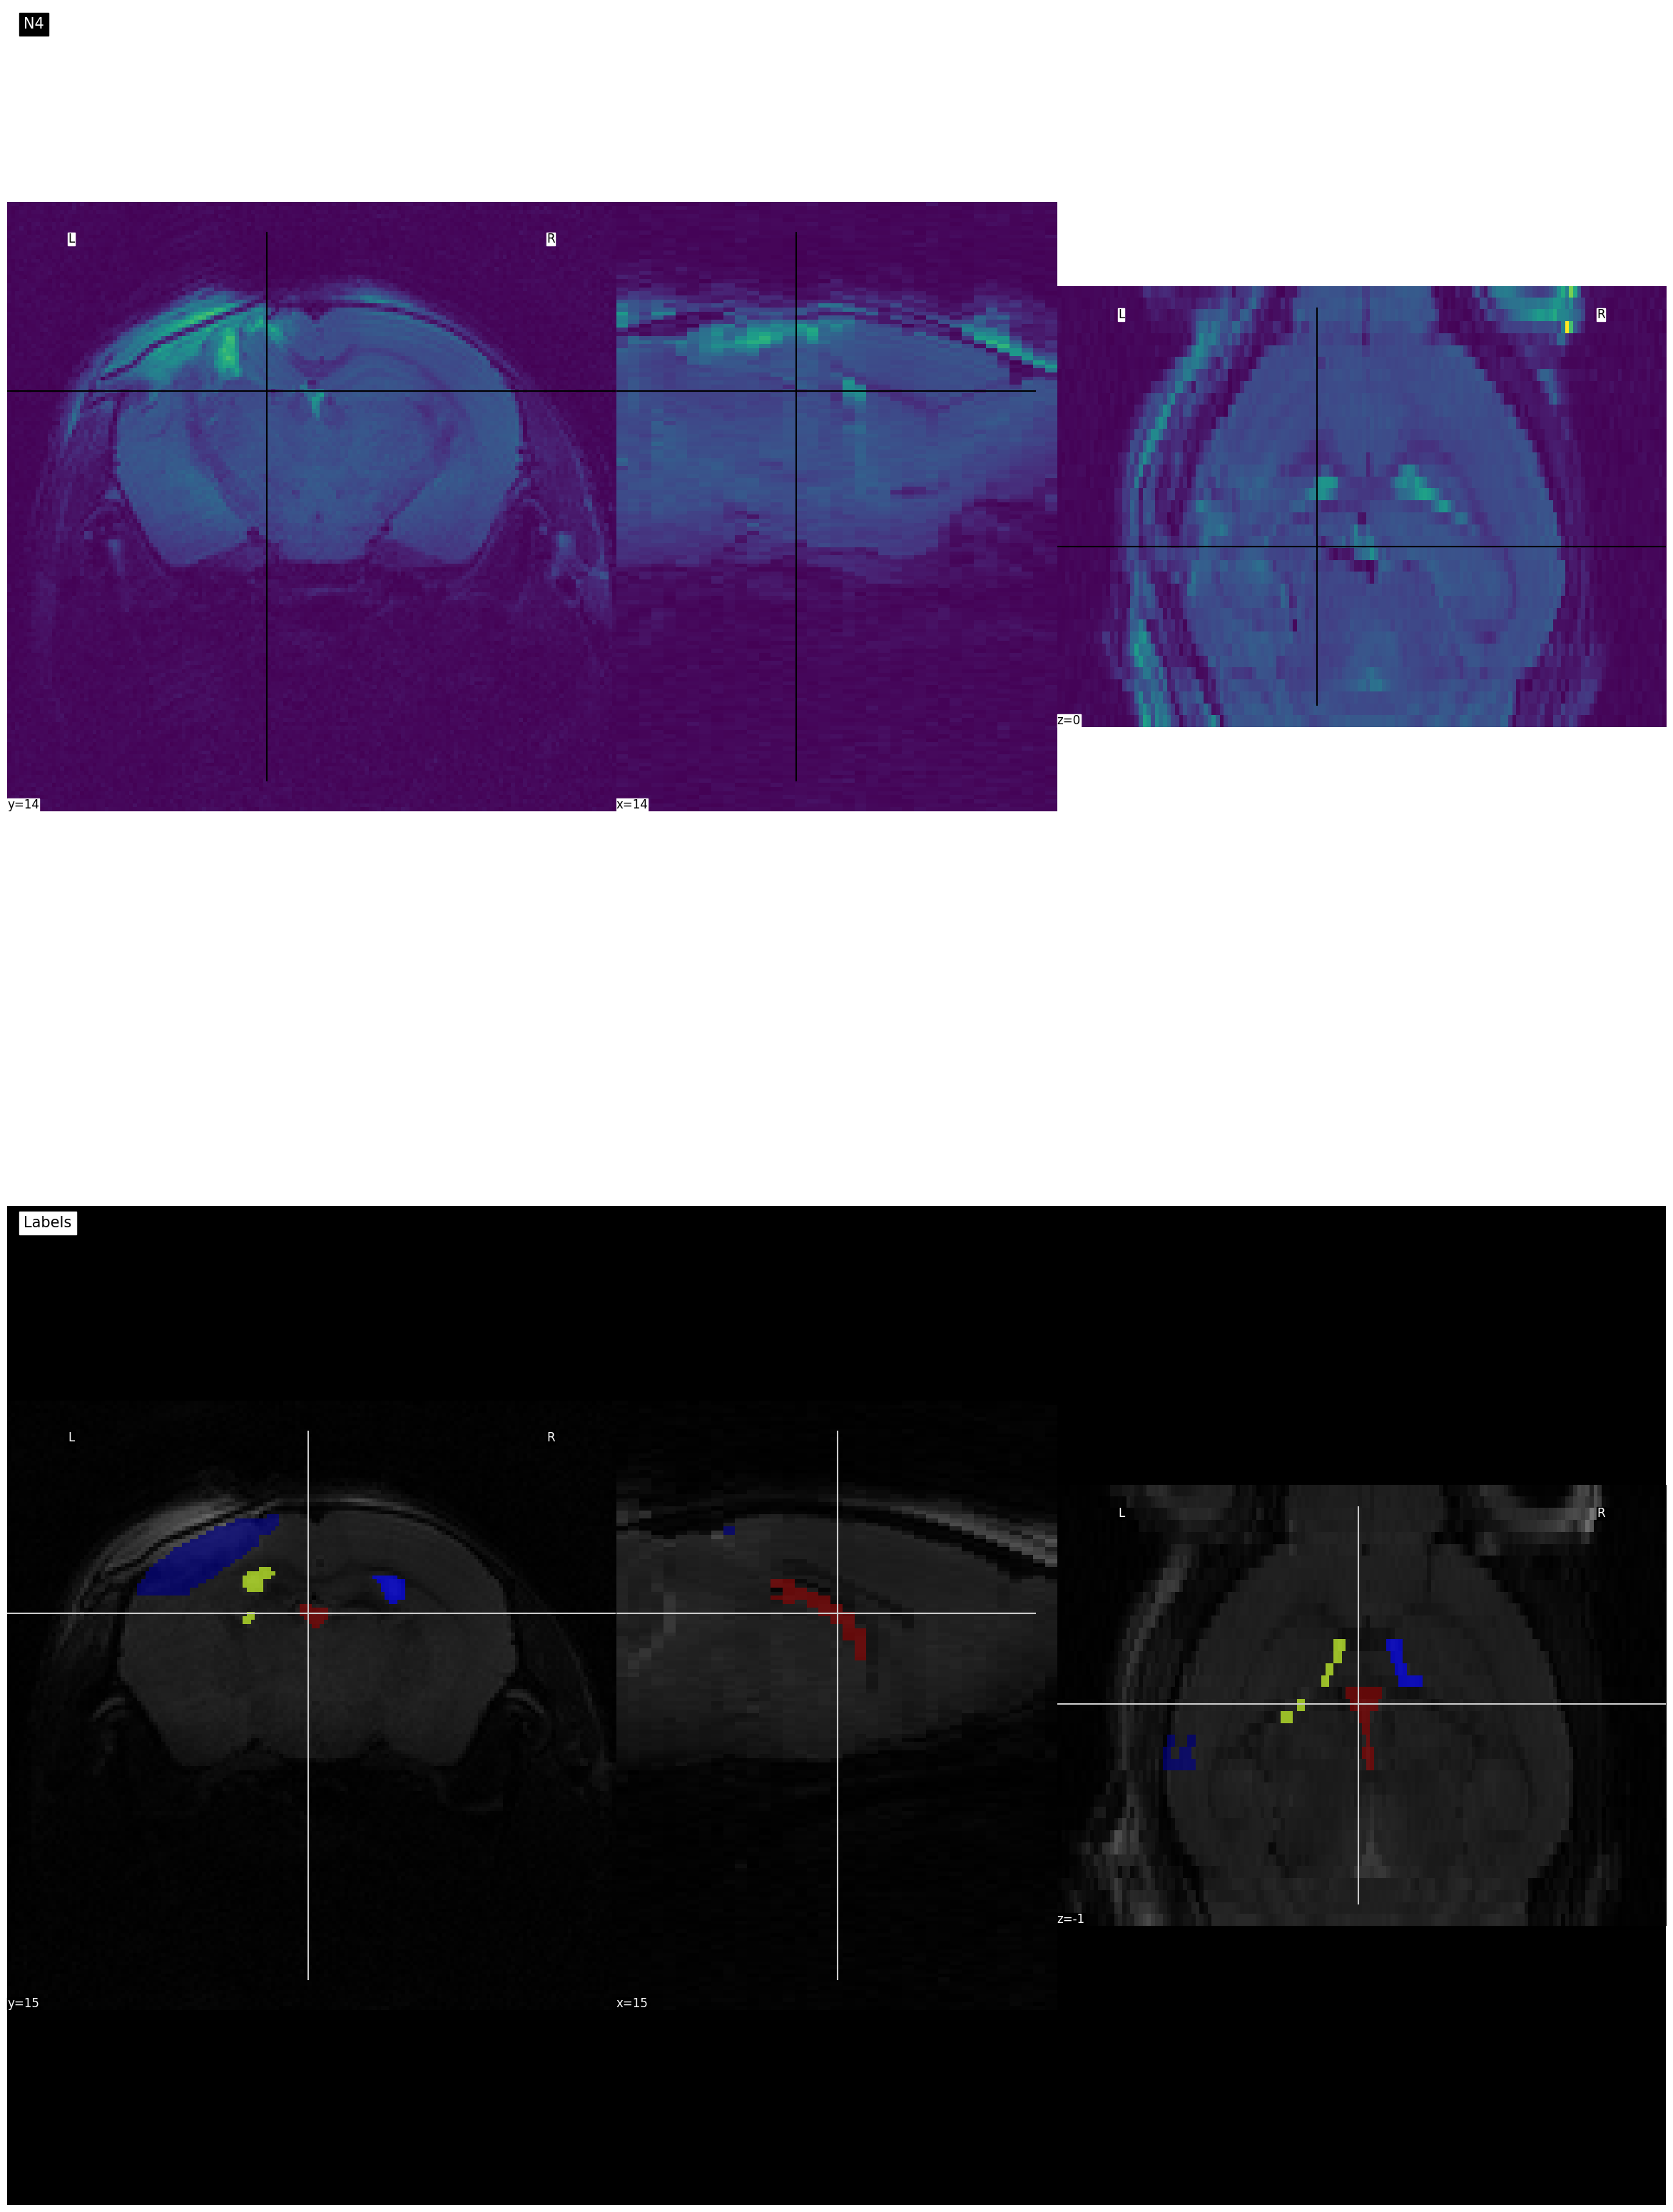

In [5]:
niimg = nl.image.load_img(file_paths['N4'])
nimask = nl.image.load_img(file_paths['Labels'])
fig, axes = plt.subplots(nrows=2, figsize=(30, 40))

# Plot 'niimg' as an anatomical image on the first subplot
nlplt.plot_img(niimg, title='N4', axes=axes[0])
# Plot 'nimask' as a region of interest (ROI) on top of 'niimg' on the fourth subplot
nlplt.plot_roi(nimask, title='Labels', bg_img=niimg, axes=axes[1], cmap='jet')
plt.show()

In [6]:
# Print matrix shape
print(f"Matrix shape: {data['N4'].shape}")

Matrix shape: (150, 150, 37)


# 6. Evaluation Metrics <a class='anchor' id='metrics'></a> [↑](#top)

In [7]:
from evaluation.metrics import *
from evaluation.losses import *

metrics = [accuracy_coefficient(domain_adaptation=True), precision_coefficient(domain_adaptation=True), 
           sensitivity_coefficient(domain_adaptation=True), specificity_coefficient(domain_adaptation=True), 
           dice_coefficient(domain_adaptation=True), iou_coefficient(domain_adaptation=True), volume_similarity_coefficient(domain_adaptation=True)]

for i in range(config['num_classes']):
    metrics.append(dice_coefficient(class_index=i, exclude_background=False, domain_adaptation=True))

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [8]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import RodentDatasets

# Main Dataset
dataset = RodentDatasets(labels=config['labels'])

# Add all datasets
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-c52-10', 'Anat')
dataset.add_dataset(config['dataset_path'], 'TBI-T2w-c52-10', 'Anat')
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-c52-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-cd1-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'TBI-T2w-c52-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
# dataset.add_dataset(config['dataset_path'], 'TBI-T2w-c52-4-Caen\\3 weeks', '', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52a-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52b-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52c-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52d-4', 'Anat', sham=True, unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-cd1-4', 'Anat', sham=True, unavailable_labels=[0,2,5,6,12,15,16])

train_and_test_ids = dataset.get_subjects_list()
print('Size of the dataset: ', len(train_and_test_ids))

# Splitting
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=config['validation_split']) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=config['test_split'])

Added 4 subjects from TBI-T1w-c52-10
Added 5 subjects from TBI-T2w-c52-10
Added 67 subjects from TBI-T1w-c52-4
Added 15 subjects from TBI-T1w-cd1-4
Added 21 subjects from TBI-T2w-c52-4
Added 9 subjects from SHAM-T1w-c52a-10
Added 21 subjects from SHAM-T1w-c52b-10
Added 49 subjects from SHAM-T1w-c52c-10
Added 2 subjects from SHAM-T1w-c52d-4
Added 5 subjects from SHAM-T1w-cd1-4
Size of the dataset:  198


In [9]:
# Sample multiple times the same subject to increase the number of samples and variability exploiting on-the-fly data augmentation
train_ids = train_ids * config['sampling_rate']
val_ids = val_ids * config['sampling_rate']
test_ids = test_ids * config['sampling_rate']
print('New size of the dataset: ', len(train_ids) + len(val_ids) + len(test_ids))

New size of the dataset:  594


In [10]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping, RandomAffine, GaussianBlur, Noise

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

augmented = Preprocessor([
    MapLabels(config['labels']),
    CorrectX10(),
    Reorient(ref_img),
    RandomAffine(rotation_range=[-10,10], scale_range=[0.95,1.05], probability=0.3),
    GaussianBlur([0,0.6], probability=0.3),
    Noise([0,0.05], probability=0.3),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='center', std=None),
])

preprocessor =  Preprocessor([
    MapLabels(config['labels']),
    CorrectX10(),
    Reorient(ref_img),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='center', std=None),
])

In [11]:
import importlib
import preprocessing.generator
importlib.reload(preprocessing.generator)
from preprocessing.generator import DomainAdaptationGenerator

# Datasets Initialization
training_generator = DomainAdaptationGenerator(train_ids, dataset, batch_size=config['batch_size'], preprocessor=augmented, config=config)
valid_generator = DomainAdaptationGenerator(val_ids, dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)
test_generator = DomainAdaptationGenerator(test_ids, dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)

print("Val IDs: ", val_ids)
print("Train IDs: ", train_ids)
print("Test IDs: ", test_ids)

Generator configuration:
- Dataset path: F:\Lesion Volume Project\backup temp\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Generator configuration:
- Dataset path: F:\Lesion Volume Project\backup temp\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Generator configuration:
- Dataset path: F:\Lesion Volume Project\backup temp\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Val IDs:  [('SHAM-T1w-c52a-10', 'CONC_fm_17_C_43'), ('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_171'), ('SHAM-T1w-c52d-4', 'TBI_AAV_PPIAKO_1762'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_15'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_2'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_17'), ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_12'), ('TBI-T2w-c52-10', 'TBI_gv_17_50'), ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1793'),

## Sanity Check

Img shape:  (8, 80, 80, 80, 1)
Labels shape:  (8, 80, 80, 80, 11)
Brain mask shape: (8, 80, 80, 80, 1)
Sham shape:  (8, 1)
Max value in X:  14.819559234993065
Min value in X:  -1.323741189384236
Unique values in Y:  [-1.  0.  1.]
Max value in Y:  1.0
Min value in Y:  -1.0
Is Sham?  yes
Unique values in Y:  [ 0  1  3  7 10]


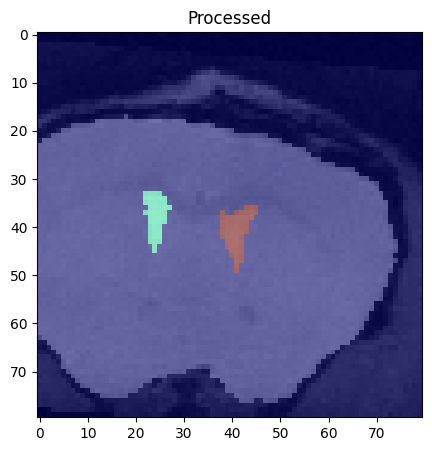

In [12]:
X,[Y,M,S]= training_generator.__getitem__(index=0) # Fetching the first batch  (X, [Seg, Sham, Ignore])

print('Img shape: ', X.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, IN_CHANNELS) 
print('Labels shape: ', Y.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, NUM_CLASSES)
print('Brain mask shape:', M.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, 1)
print('Sham shape: ',S.shape) # Should be equal to (BATCH_SIZE, 1)

# print max and min values in X
print("Max value in X: ", np.max(X))
print("Min value in X: ", np.min(X))

# Check if Y is one-hot encoded and has 4 different channels with label 1
print("Unique values in Y: ", np.unique(Y))
# print max and min values in Y
print("Max value in Y: ", np.max(Y))
print("Min value in Y: ", np.min(Y))

sample=3
layer=config['input_shape'][2]//2

yhat=Y[sample]
yhat[yhat==-1]=0 # Convert all -1 to 0
yhat = np.argmax(yhat, axis=-1)

# Print 'yes' if sham
print("Is Sham? ", 'yes' if S[sample] else 'no')
print("Unique values in Y: ", np.unique(yhat))
plt.figure(figsize=(15, 5))
plt.imshow(np.rot90(X[sample,:,:,layer,0], k=-1),cmap='gray')
plt.imshow(np.rot90(yhat[:,:,layer], k=-1), cmap='jet', alpha=0.6)
plt.imshow(np.rot90(M[sample,:,:,layer,0], k=-1), cmap='gray', alpha=0.2)
plt.title("Processed")

plt.show()

## Show Data Split Distribution

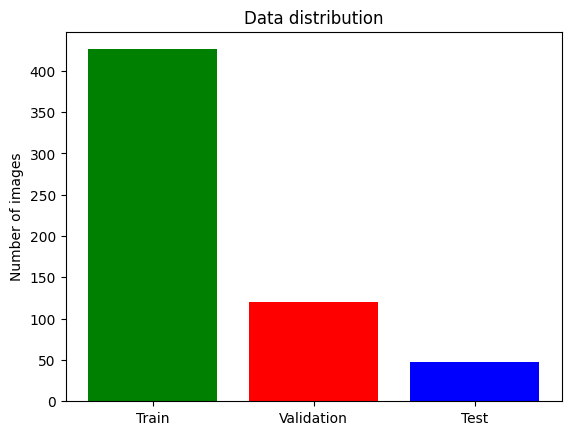

In [13]:
# Show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Validation", "Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red','blue'])

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [14]:
from models.networks import *

# Example usage:
filters = [16, 32, 64, 128, 256]
filters = [4, 8, 16, 32, 64]
model = mt_r_net_3d((None,None,None), config['in_channels'], config['num_classes'], filters, attention=False, residual=True, with_classifier=True)

## Overview

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_10 (Conv3D)             (None, None, None,   112         ['input_1[0][0]']                
                                None, 4)                                                          
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   16         ['conv3d_10[0][0]']              
 rmalization)                   None, 4)                                                      

## Callbacks

In [16]:
import datetime
csv_logger = CSVLogger('../results/'+config['model_name']+'/training.log', separator=',', append=False)
log_dir = "../results/"+config['model_name']+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "../results/"+config['model_name']+"/checkpoint/"

callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
        csv_logger
    ]

## Training

In [17]:
steps = len(train_ids) // config['batch_size']
val_steps = len(val_ids) // config['batch_size']

roi_loss = diceCELoss(smooth=1e-5, batch_wise=True, gamma=0.8, domain_adaptation=True)
skullstrip_loss = diceBCELoss(alpha=0.6, smooth=1e-5, batch_wise=True)
sham_loss = weightedBinaryCrossentropy()

losses = {
    'regions': roi_loss,
    'classifier': sham_loss,
    'brain_mask': skullstrip_loss
}

loss_weights = {
    'regions': 1,
    'classifier': 1,
    'brain_mask': 1,
}

metrics = {
    'regions': metrics,
    'classifier': 'accuracy',
    'brain_mask': dice_coefficient(class_index=0, exclude_background=False)
}

model.compile(loss=losses, optimizer=tf.keras.optimizers.Nadam(learning_rate=config['lr']), metrics = metrics, loss_weights=loss_weights)
history =  model.fit(training_generator,epochs=config['epochs'], steps_per_epoch=steps, callbacks= callbacks, validation_data=valid_generator, validation_steps=val_steps)

Epoch 1/300
53/53 [==============================] - ETA: 0s - loss: 0.8419 - regions_loss: 0.2617 - brain_mask_loss: 0.1732 - classifier_loss: 0.3895 - regions_mean_accuracy: 0.9792 - regions_mean_precision: 0.0667 - regions_mean_sensitivity: 0.0590 - regions_mean_specificity: 0.9848 - regions_mean_dice: 0.0542 - regions_mean_iou: 0.0354 - regions_mean_volume_similarity: 0.4170 - regions_class_0_dice: 0.6290 - regions_class_1_dice: 0.1347 - regions_class_2_dice: 0.0326 - regions_class_3_dice: 8.0654e-04 - regions_class_4_dice: 0.0307 - regions_class_5_dice: 0.1382 - regions_class_6_dice: 0.0203 - regions_class_7_dice: 0.0027 - regions_class_8_dice: 0.0342 - regions_class_9_dice: 0.1477 - regions_class_10_dice: 3.9757e-06 - brain_mask_class_0_dice: 0.8406 - classifier_accuracy: 0.5377

INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


53/53 [==============================] - 238s 4s/step - loss: 0.8419 - regions_loss: 0.2617 - brain_mask_loss: 0.1732 - classifier_loss: 0.3895 - regions_mean_accuracy: 0.9792 - regions_mean_precision: 0.0667 - regions_mean_sensitivity: 0.0590 - regions_mean_specificity: 0.9848 - regions_mean_dice: 0.0542 - regions_mean_iou: 0.0354 - regions_mean_volume_similarity: 0.4170 - regions_class_0_dice: 0.6290 - regions_class_1_dice: 0.1347 - regions_class_2_dice: 0.0326 - regions_class_3_dice: 8.0654e-04 - regions_class_4_dice: 0.0307 - regions_class_5_dice: 0.1382 - regions_class_6_dice: 0.0203 - regions_class_7_dice: 0.0027 - regions_class_8_dice: 0.0342 - regions_class_9_dice: 0.1477 - regions_class_10_dice: 3.9757e-06 - brain_mask_class_0_dice: 0.8406 - classifier_accuracy: 0.5377 - val_loss: 3.1628 - val_regions_loss: 0.4384 - val_brain_mask_loss: 0.4513 - val_classifier_loss: 2.2554 - val_regions_mean_accuracy: 0.9385 - val_regions_mean_precision: 0.0165 - val_regions_mean_sensitivity: 

INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


53/53 [==============================] - 163s 3s/step - loss: 0.4725 - regions_loss: 0.1599 - brain_mask_loss: 0.0929 - classifier_loss: 0.2019 - regions_mean_accuracy: 0.9941 - regions_mean_precision: 0.2674 - regions_mean_sensitivity: 0.1759 - regions_mean_specificity: 0.9980 - regions_mean_dice: 0.2164 - regions_mean_iou: 0.1506 - regions_mean_volume_similarity: 0.5630 - regions_class_0_dice: 0.9545 - regions_class_1_dice: 0.3949 - regions_class_2_dice: 0.1074 - regions_class_3_dice: 0.0136 - regions_class_4_dice: 0.1724 - regions_class_5_dice: 0.5562 - regions_class_6_dice: 0.1950 - regions_class_7_dice: 0.0068 - regions_class_8_dice: 0.1919 - regions_class_9_dice: 0.5184 - regions_class_10_dice: 0.0071 - brain_mask_class_0_dice: 0.9157 - classifier_accuracy: 0.8231 - val_loss: 1.7409 - val_regions_loss: 0.1746 - val_brain_mask_loss: 0.1363 - val_classifier_loss: 1.4123 - val_regions_mean_accuracy: 0.9899 - val_regions_mean_precision: 0.2396 - val_regions_mean_sensitivity: 0.2177 -

INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


53/53 [==============================] - 164s 3s/step - loss: 0.4313 - regions_loss: 0.1452 - brain_mask_loss: 0.0743 - classifier_loss: 0.1940 - regions_mean_accuracy: 0.9941 - regions_mean_precision: 0.3666 - regions_mean_sensitivity: 0.2653 - regions_mean_specificity: 0.9978 - regions_mean_dice: 0.2967 - regions_mean_iou: 0.1993 - regions_mean_volume_similarity: 0.6632 - regions_class_0_dice: 0.9573 - regions_class_1_dice: 0.4862 - regions_class_2_dice: 0.2379 - regions_class_3_dice: 0.0823 - regions_class_4_dice: 0.2886 - regions_class_5_dice: 0.6083 - regions_class_6_dice: 0.3272 - regions_class_7_dice: 0.0066 - regions_class_8_dice: 0.2724 - regions_class_9_dice: 0.5902 - regions_class_10_dice: 0.0673 - brain_mask_class_0_dice: 0.9365 - classifier_accuracy: 0.8349 - val_loss: 0.4379 - val_regions_loss: 0.1454 - val_brain_mask_loss: 0.0615 - val_classifier_loss: 0.2131 - val_regions_mean_accuracy: 0.9938 - val_regions_mean_precision: 0.3737 - val_regions_mean_sensitivity: 0.3344 -

INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_da_unet_ep500_05-03-2025_11-42/checkpoint\assets


53/53 [==============================] - 164s 3s/step - loss: 0.3619 - regions_loss: 0.1373 - brain_mask_loss: 0.0657 - classifier_loss: 0.1410 - regions_mean_accuracy: 0.9948 - regions_mean_precision: 0.4105 - regions_mean_sensitivity: 0.3455 - regions_mean_specificity: 0.9979 - regions_mean_dice: 0.3551 - regions_mean_iou: 0.2386 - regions_mean_volume_similarity: 0.7397 - regions_class_0_dice: 0.9624 - regions_class_1_dice: 0.5361 - regions_class_2_dice: 0.3214 - regions_class_3_dice: 0.1808 - regions_class_4_dice: 0.3734 - regions_class_5_dice: 0.6360 - regions_class_6_dice: 0.3928 - regions_class_7_dice: 0.0289 - regions_class_8_dice: 0.3460 - regions_class_9_dice: 0.5874 - regions_class_10_dice: 0.1478 - brain_mask_class_0_dice: 0.9421 - classifier_accuracy: 0.8797 - val_loss: 0.2939 - val_regions_loss: 0.1244 - val_brain_mask_loss: 0.0557 - val_classifier_loss: 0.0958 - val_regions_mean_accuracy: 0.9954 - val_regions_mean_precision: 0.5019 - val_regions_mean_sensitivity: 0.2513 -

KeyboardInterrupt: 

In [ ]:
_history = history.history

# Load the best model
model.load_weights(checkpoint_path)

# Save the model
model.save("../results/"+config['model_name']+"/save_" + config['model_name'] + ".h5")

# 9. Results <a class='anchor' id='results'></a> [↑](#top)
## History

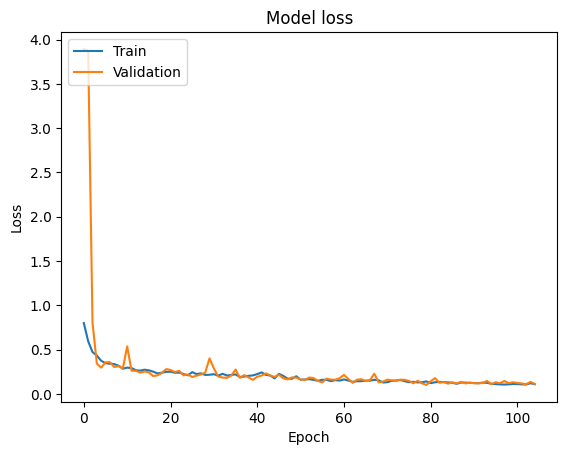

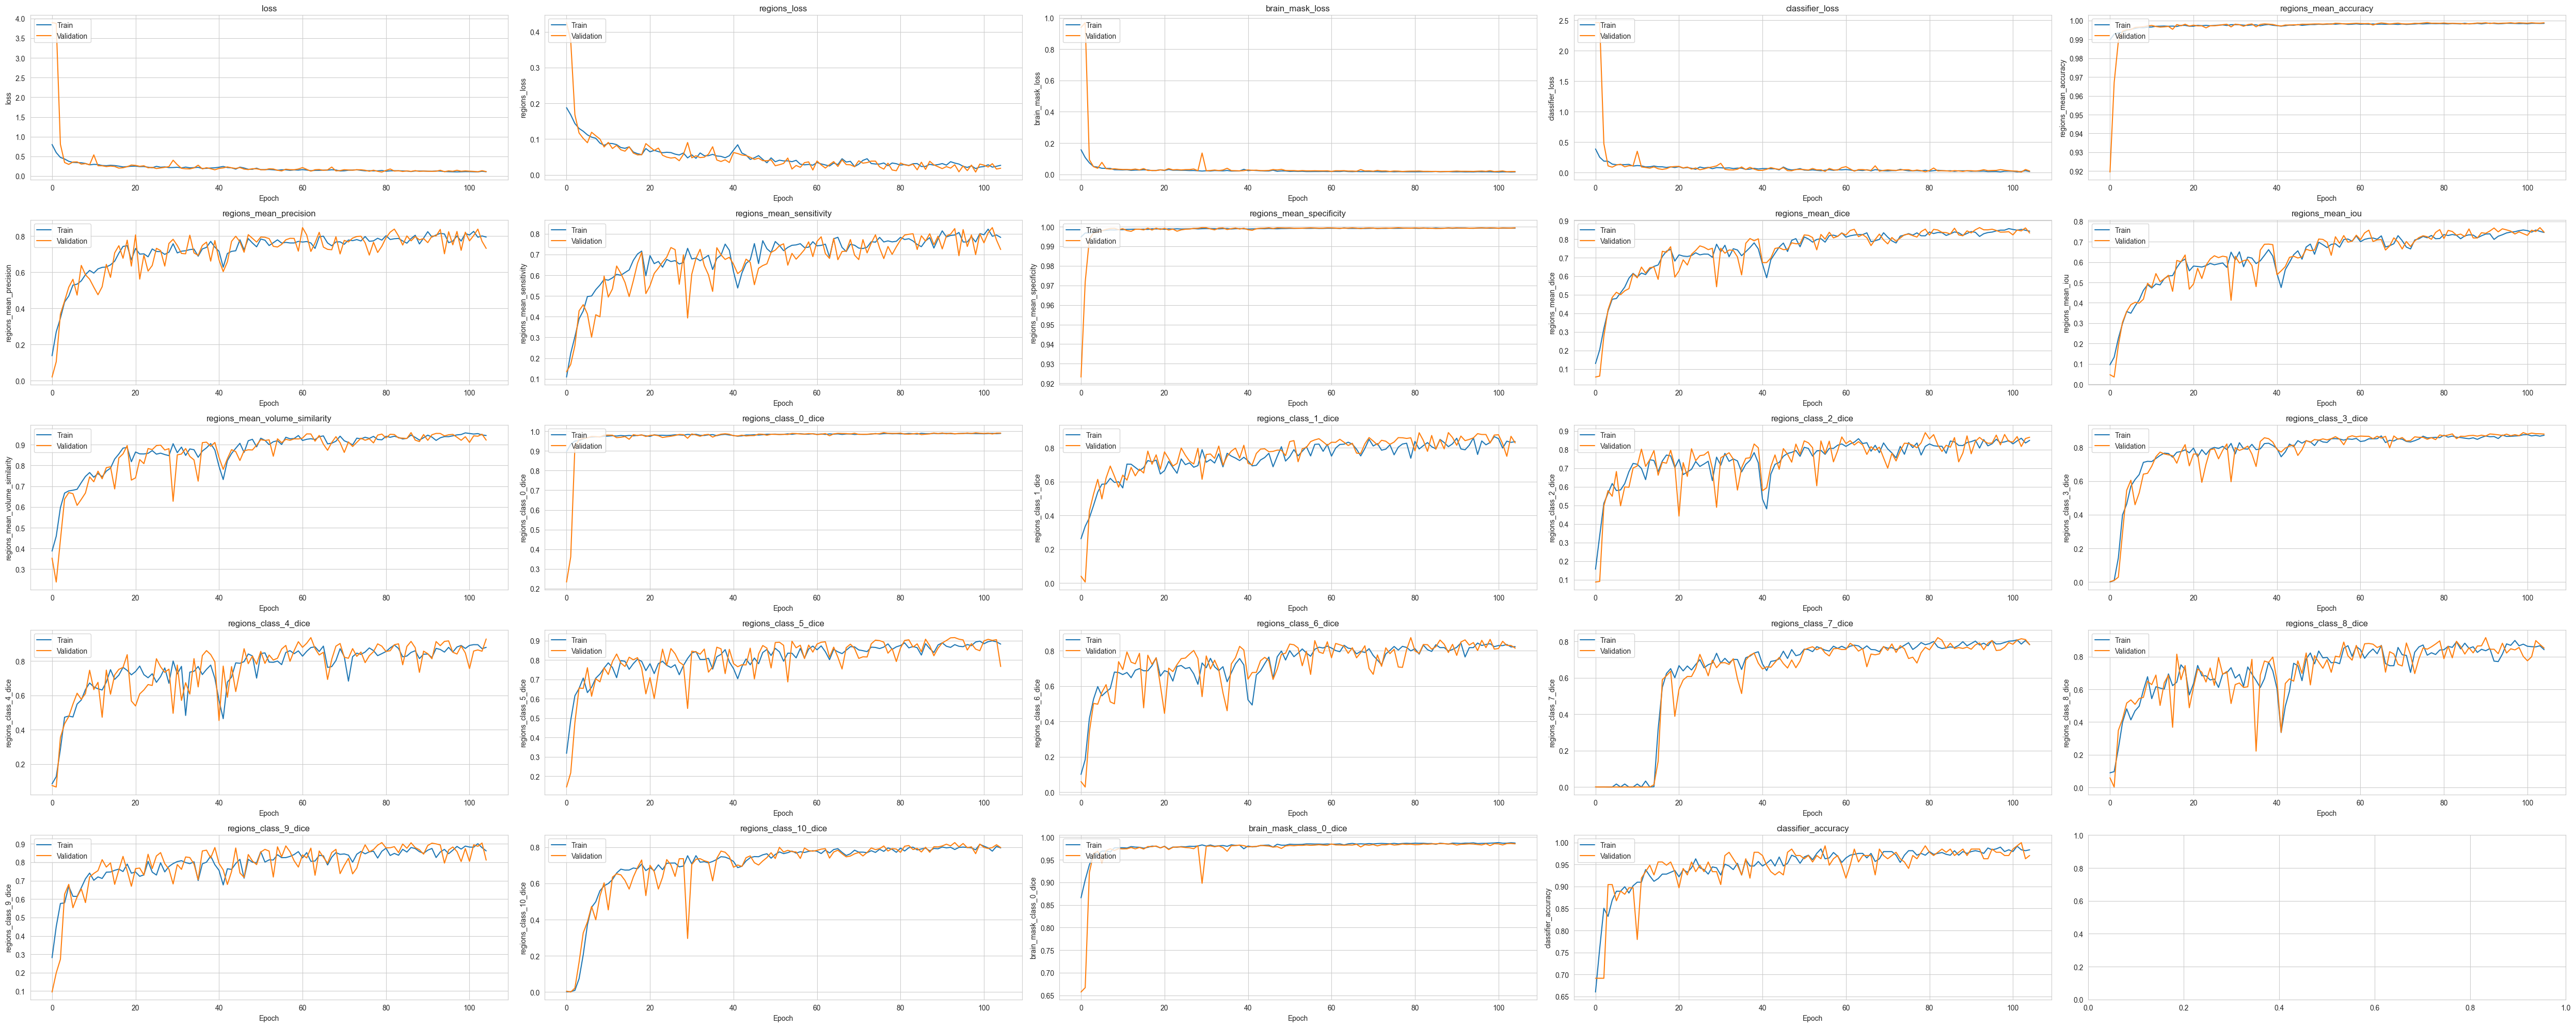

In [ ]:
from utils.visualization import plot_history, plot_loss
plot_loss(_history, path='../results/'+config['model_name']+'/' + 'loss_history.png', log=False)
plot_history(_history, path='../results/'+config['model_name']+'/' + 'metrics_history.png', figsize=(50,20))

## Predictions

In [ ]:
import utils.visualization  
importlib.reload(utils.visualization)
from utils.visualization import plot_domain_adaptation
# To plot the pre-processed data we can use our custom test generator with batch_size equal to 1
test_plot_generator = DomainAdaptationGenerator(ids=test_ids, loader=dataset, batch_size=1, preprocessor=preprocessor, config=config, shuffle=False)
for index in range(len(test_plot_generator))[:15]:
    plot_domain_adaptation(test_ids, index, test_plot_generator, model)

Generator configuration:
- Dataset path: F:\Lesion Volume Project\backup temp\dataset_roi_cot
- Dimensions: (64, 64, 64)
- Batch size: 1
- Number of input channels: 1
- Number of classes: 11
- Shuffle: False

1/1 [==============================] - 1s 1s/step
ID: ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1784')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_13')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_162_5W')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_130_5W')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 31ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_33')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_128_5M')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_20')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 28ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_32')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 28ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_47')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_7')
Real condition: [0.] Predicted condition: [0.015]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('TBI-T2w-c52-4-Caen\\3 weeks', '20240919_112755_LS_TBI_J21_C4S7_190924_1_1')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 28ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_18')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_40')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_130_5M')
Real condition: [1.] Predicted condition: [0.923]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 29ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_9')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=31, description='SLICE', max=63), Output()), _dom_classes=('widget-inter…

# 10. Evaluation <a class='anchor' id='eval'></a> [↑](#top)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 13s 2s/step - loss: 0.1549 - regions_loss: 0.0340 - brain_mask_loss: 0.0180 - classifier_loss: 0.0466 - regions_mean_accuracy: 0.9979 - regions_mean_precision: 0.7983 - regions_mean_sensitivity: 0.8093 - regions_mean_specificity: 0.9988 - regions_mean_dice: 0.8310 - regions_mean_iou: 0.7374 - regions_mean_volume_similarity: 0.9269 - regions_class_0_dice: 0.9860 - regions_class_1_dice: 0.7524 - regions_class_2_dice: 0.7346 - regions_class_3_dice: 0.8813 - regions_class_4_dice: 0.8954 - regions_class_5_dice: 0.8895 - regions_class_6_dice: 0.7411 - regions_class_7_dice: 0.8310 - regions_class_8_dice: 0.8964 - regions_class_9_dice: 0.8876 - regions_class_10_dice: 0.8007 - brain_mask_class_0_dice: 0.9860 - classifier_accuracy: 0.9643
test loss, test acc: [0.1549423784017563, 0.03398291394114494, 0.01797749288380146, 0.046589095145463943, 0.9978727102279663, 0.7983002066612244, 0.8093346953392029, 0.9988394975662231, 0.831002116203

In [ ]:
from utils.utils import save_metrics, save_model_info

# Print test
print(test_ids)
# Save metrics, model info, and augmentation info
print("Model name: ", config['model_name'])
save_metrics(results, model, path=f'../results/{config["model_name"]}/metrics.txt')
save_model_info(model, config, filters, test_ids, path=f'../results/{config["model_name"]}/model_info.txt')
augmented.save_configuration(path=f'../results/{config["model_name"]}/augmentation_config.txt')
preprocessor.save_configuration(path=f'../results/{config["model_name"]}/preprocessor_config.txt')

[('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1784'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_13'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_162_5W'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_130_5W'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_33'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_128_5M'), ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_20'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_32'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_47'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_7'), ('TBI-T2w-c52-4-Caen\\3 weeks', '20240919_112755_LS_TBI_J21_C4S7_190924_1_1'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_18'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_40'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_130_5M'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_9'), ('TBI-T2w-c52-4', 'TBI_gv_20_68'), ('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_195'), ('SHAM-T1w-cd1-4', 'TBI_PTE_fm_20_199'), ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_28'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1784'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_13'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_162_5W'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_130_5W'), ('SHAM-T1w-c52c-1